# Serum proteomic pattern diagnostics

Dataset from the FDA-NCI Clinical Proteomics Program Databank [1,2].

Each column of `A` represents measurements taken from a patient. There are 216 columns representing 216 patients, out of which 121 are ovarian cancer patients and 95 are normal patients.

Each row represents the ion intensity level at a specific mass-charge value indicated in MZ. There are 2000 mass-charge values, and each row represents the ion-intensity levels of the patients at that particular mass-charge value.

The variable `grp` holds the index information as to which of these samples represent cancer patients and which ones represent normal patients.

- [1] T.P. Conrads, et al., ["High-resolution serum proteomic features for ovarian detection"](https://doi.org/10.1677/erc.0.0110163), Endocrine-Related Cancer, 11, 2004, pp. 163-178.
- [2] E.F. Petricoin, et al., ["Use of proteomic patterns in serum to identify ovarian cancer"](https://doi.org/10.1016/s0140-6736(02)07746-2), Lancet, 359(9306), 2002, pp. 572-577.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

ovariancancer_obs_path = 'data/ovariancancer_obs.csv'
ovariancancer_grp_path = 'data/ovariancancer_grp.csv'

A = np.genfromtxt(ovariancancer_obs_path, delimiter=',').transpose() #generate a matrix from the data contained in the file
f = open(ovariancancer_grp_path) #groups
grp = np.array(f.read().split("\n"))
grp = grp[grp != ''] #remove the empty entries

How many patients? How many features?

Number of features is the number of rows
Number of patients is the number of columns

In [21]:
n_features = A.shape[0]
n_patients = A.shape[1]
print("%d features" % n_features)
print("%d patients" % n_patients)

4000 features
216 patients


How many patiens with and without cancer are there in the dataset?

In [22]:
numberOfPatiensWithCancer = len(grp[grp == 'Cancer']) # this is a mask and then you make 
numberOfPatiensWithoutCancer = len(grp[grp == 'Normal']) 
print("%d patients with cancer" % numberOfPatiensWithCancer)
print("%d patients without cancer" % numberOfPatiensWithoutCancer)

121 patients with cancer
95 patients without cancer


Choose two proteins (between 1 and 2000), and make a scatterplot of the corresponding values plotting with different colors the data corresponding to patients with and without cancer. Can you easily distinguish between patients with/without cancer?

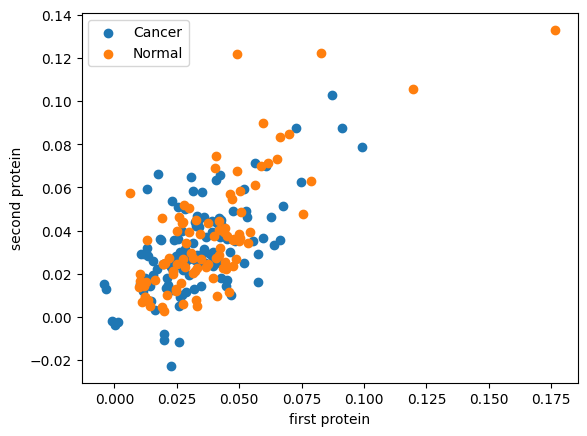

In [29]:
feature1 = 0
feature2 = 1
# A[feature1, grp == 'Cancer'] extracts the data for feature one where the group is labeled as Cancer
plt.scatter(A[feature1, grp == 'Cancer'], A[feature2, grp == 'Cancer'], label = 'Cancer')
plt.scatter(A[feature1, grp == 'Normal'], A[feature2, grp == 'Normal'], label = 'Normal')
plt.xlabel("first protein")
plt.ylabel("second protein")
plt.legend()

Repeat the previous point, this time by considering three proteins.

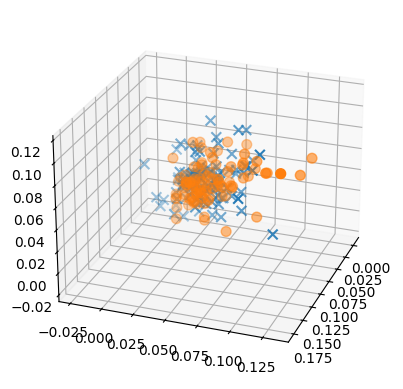

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
feature1 = 0
feature2 = 1
feature3 = 2

ax.scatter(A[feature1, grp == 'Cancer'], A[feature2, grp == 'Cancer'], A[feature3, grp == 'Cancer'], marker='x', s=50)
ax.scatter(A[feature1, grp == 'Normal'], A[feature2, grp == 'Normal'], A[feature3, grp == 'Normal'], marker='o', s=50)

ax.view_init(25,20)

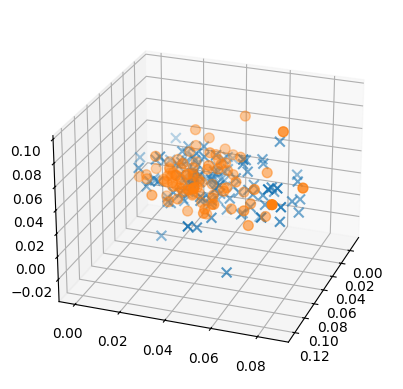

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
firstProtein = np.random.randint(0,3999)
secondProtein = np.random.randint(0,3999)
thirdProtein = np.random.randint(0,3999)

ax.scatter(A[firstProtein, grp == 'Cancer'], A[secondProtein, grp == 'Cancer'], A[thirdProtein, grp == 'Cancer'], marker='x', s=50)
ax.scatter(A[firstProtein, grp == 'Normal'], A[secondProtein, grp == 'Normal'], A[thirdProtein, grp == 'Normal'], marker='o', s=50)

ax.view_init(25,20)

## Principal Components Analysis

When you do the principal component analysis, you have to do it globally by mixing patients with cancer and without. The goal here is to try to predict the cancer or not, so we cannot use this information.
Doing PCA on the whole dataset and then a posteriori check whether this is useful to cluster between cancer or not

In numpy, None can be used to add a new axis to an array. This is useful for broadcasting: mechanism that allows np to perform arithmetic operations on array of different shapes

In [35]:
A_mean = np.mean(A, axis = 1) #np.mean calculates the mean expression level of each protein across all samples
U, s, VT = np.linalg.svd(A - A_mean[:, None], full_matrices = False)
A_mean
# A_mean will be 1 dimension array of length 4000 where each element represents the mean expression level of a corresponding protein
#axis=0 in np.mean operates along the columns (down the rows). For a 2d array it computess the mean of each column
#axis=1 in np.mean operates along the rows (across the columns). For a 2d array it computess the mean of each row

array([0.03551712, 0.0340071 , 0.03109404, ..., 0.02930945, 0.02850931,
       0.0283082 ])

Perform PCA on the data. Then, plot the trend of
- the singular values $\sigma_k$
- the cumulate fraction of singular values: $\frac{\sum_{i=1}^{k} \sigma_i}{\sum_{i=1}^{q} \sigma_i}$
- the fraction of the "explained variance": $\frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{q} \sigma_i^2}$

Text(0.5, 1.0, 'explained variance')

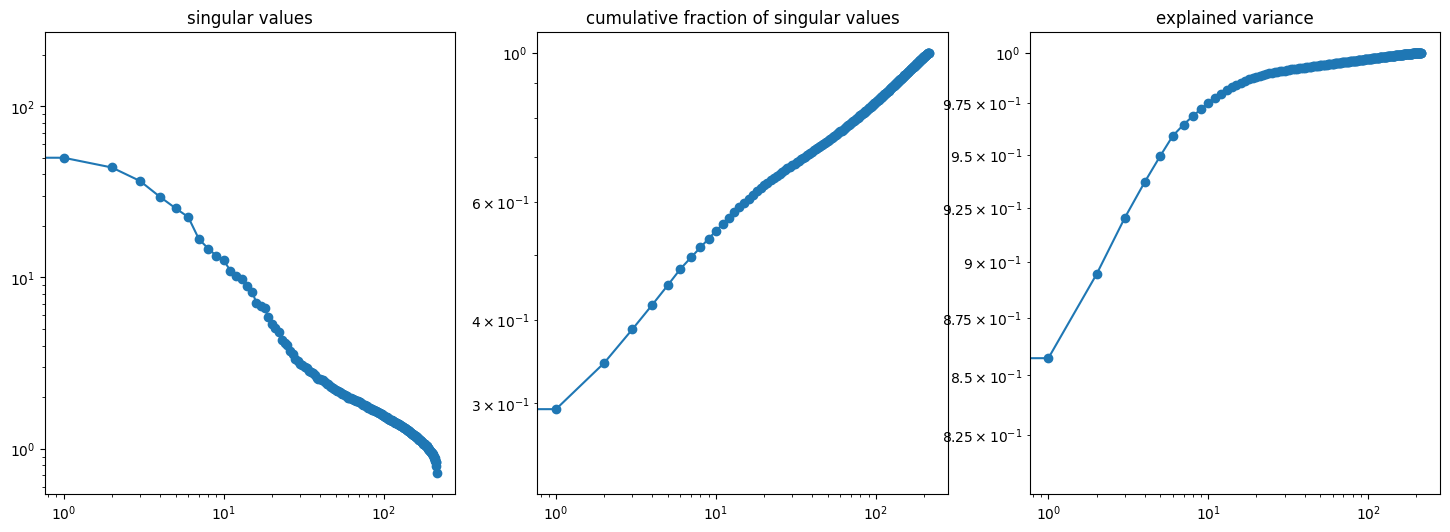

In [37]:
fig, axs = plt.subplots(1,3, figsize = (18,6))

axs[0].loglog(s[:-1], 'o-') # the first singular value is very large wrt to the other, the last one is almost zero and you can remove it
axs[0].set_title("singular values")


axs[1].loglog(np.cumsum(s) / np.sum(s), 'o-') 
axs[1].set_title("cumulative fraction of singular values")


axs[2].loglog(np.cumsum(s**2) / np.sum(s**2), 'o-') 
axs[2].set_title("explained variance")

By looking just at the first ptincipal components, these contains 85/90% of the variance, so our hope is that this variability is related to the presence or not of the cancer.

There are two main ways to represent the data matrix X:
1) X is an MxN matrix, where M is the number of features and N is the number of samples. Each column represents a different sample
2) X is a NxM matrix, where each row represents a different sample

Both representations are valid, the key is to be consistent within your analysis.

Regardless of the representation, the first step is to subtract the mean from each feature/column to center the data.

Then you perform the SVD on the centered matrix

The important outputs from the SVDdepend on the representation:
- if X is MxN, the principal axes are the columns of U
- if X is NXm, the principal axes are the columns of V

To compute the principal components of a new sample x, you subtract the mean and project onto the principal axes:
- if using U, compute U.T @ (x - x_mean)
- if using V, compute (x - x_mean) @ V.T

the two representations are equivalent, just different ways of expressing the same thing

Make a scatterplot of the first two principal components of the patients.

-7.96705045727029
-9.232076037880837
-19.916176608019086
-12.532131293246046
-29.609009076591036
-22.251609973832394
12.405781914562978
2.7826081932361975
-15.120244803480475
-12.293926706977954
-31.03414446629113
-24.257070136624783
-19.804219099818287
15.419099688874777
9.37690507577144
-13.815030369756352
-18.880973965136818
-12.854222630702207
-16.48778724566098
-31.427652111174908
13.496044548759066
-15.258005310642007
9.62158694985151
-9.450758402703698
-5.378601714649251
-20.93373718012147
-10.627635969798224
-2.1959512316383876
11.405021757982711
4.787072202730599
4.420307763917228
-21.905102021448457
-13.265806954594972
-6.396590531945492
6.907341908391847
1.8522215320418804
-5.9170361939483636
-14.25941479758487
-42.502307829414235
-22.915726101874473
3.0713468600584832
-1.4373752158969708
-9.227074879037637
-2.530404505131277
-7.567272470144344
-13.963957727123343
-33.86387599444883
-2.169613605409781
15.24039209853268
-9.573668211414526
11.591648246958332
6.610274017134314


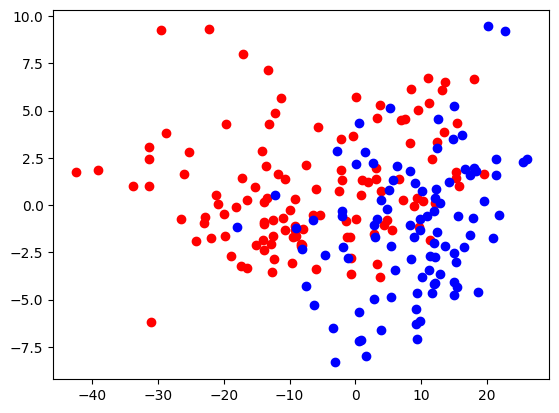

In [44]:
for i_patient in range(n_patients):
# A[:, i_patient] all the features for a fixed patient
# A[:, i_patient] - A_mean then we remove the mean 
    if grp[i_patient] == 'Cancer':
        color = 'r'
    else:
        color = 'b'

    plt.scatter(np.inner(U[:,0],A[:, i_patient] - A_mean), #first principal component of the i-th patient
                np.inner(U[:,1],A[:, i_patient] - A_mean), color = color) #second principal component of the i-th patient

Make a scatterplot of the first three principal components of the patients.

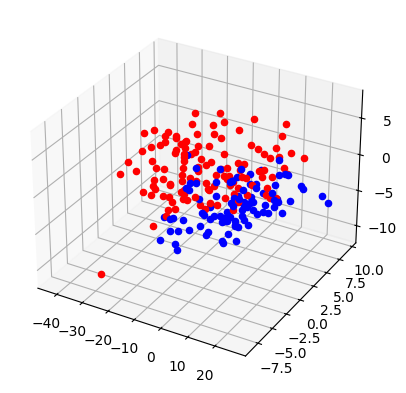

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i_patient in range(n_patients):
# A[:, i_patient] all the features for a fixed patient
# A[:, i_patient] - A_mean then we remove the mean 
    if grp[i_patient] == 'Cancer':
        color = 'r'
    else:
        color = 'b'

    ax.scatter(np.inner(U[:,0],A[:, i_patient] - A_mean), #first principal component of the i-th patient
                np.inner(U[:,1],A[:, i_patient] - A_mean), 
                np.inner(U[:,2],A[:, i_patient] - A_mean), color = color) #second principal component of the i-th patient

np.inner is used to project the data of each patient onto the principal components obtained from PCA, facilitating visualization of the patients' data in a reduced-dimensional space. This helps understand how patients' data clusters or separates based on the principal components, which capture the most significant patterns of variability in the original data-

U[:, 0] represents the first principal component (a vector) obtained from PCA.
U[:, 1] represents the second principal component (a vector) obtained from PCA.
These vectors represent the directions in feature space along which the data has maximum variance.